In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def extract_feature(file_name, mfcc=True, chroma=False, mel=False):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
     
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Delta and Delta-Delta
        # delta = librosa.feature.delta(mfccs)
        # delta2 = librosa.feature.delta(mfccs, order=2)
        # delta_mean = np.mean(delta.T, axis=0)
        # delta2_mean = np.mean(delta2.T, axis=0)

        # Stack all MFCC-related
        # mfcc_combined = np.hstack((mfccs_mean, delta_mean))
        result = np.hstack((result, mfccs_mean))

    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))

    # Simple spectral features
    # spec_centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
    # spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sample_rate).T, axis=0)
    # spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)

    
    return result


In [3]:
emotions = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
observed_emotions = [
        'neutral',
        'calm',
        'happy',
        'sad',
        'angry',
        'fearful',
        'disgust',
        'surprised']

In [4]:
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob('audio/*/Actor_*/**/*.wav', recursive=True):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, train_size=0.80, random_state=9)


In [5]:
x_train, x_test, y_train, y_test= load_data(test_size=0.2)

In [6]:
print((x_train.shape[0], x_test.shape[0]))

(1961, 491)


In [7]:
print("Feature shape per sample:", x_train[0].shape)

Feature shape per sample: (180,)


In [8]:
print(x_train.shape[1])

180


In [9]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

### MLPClassifier

In [10]:
model = MLPClassifier(alpha=0.01, batch_size = 256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [11]:
model.fit(x_train, y_train_encoded)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [12]:
y_pred=model.predict(x_test)

In [13]:
accuracy = accuracy_score(y_true=y_test_encoded, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 68.84%


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test_encoded, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.69      0.76        85
           1       0.56      0.99      0.72        76
           2       0.48      0.74      0.58        34
           3       0.70      0.66      0.68        59
           4       0.79      0.70      0.74        74
           5       0.69      0.64      0.67        45
           6       0.86      0.47      0.61        78
           7       0.79      0.55      0.65        40

    accuracy                           0.69       491
   macro avg       0.71      0.68      0.68       491
weighted avg       0.73      0.69      0.69       491



In [15]:
matrix = confusion_matrix(y_test_encoded, y_pred)
print(matrix)

[[59  2  9  6  3  2  1  3]
 [ 0 75  1  0  0  0  0  0]
 [ 3  3 25  1  1  0  1  0]
 [ 3  5  5 39  4  0  3  0]
 [ 2 11  0  1 52  5  0  3]
 [ 0 13  1  0  1 29  1  0]
 [ 3 19  3  9  4  3 37  0]
 [ 1  5  8  0  1  3  0 22]]


In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(512, 256, 128) ,
                          max_iter=1000,
                          alpha=0.0001,            
                          batch_size=64,           
                          learning_rate_init = 0.001,  
                          early_stopping=True,
                          validation_fraction=0.1,
                          random_state=42,
                          solver='adam'
                         )
    )
])

pipeline.fit(x_train, y_train_encoded)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=64, early_stopping=True,
                               hidden_layer_sizes=(512, 256, 128),
                               max_iter=1000, random_state=42))])

In [17]:
y_pred=pipeline.predict(x_test)

In [18]:
accuracy = accuracy_score(y_true=y_test_encoded, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 77.39%


In [19]:
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.68      0.77        85
           1       0.74      0.96      0.84        76
           2       0.70      0.56      0.62        34
           3       0.71      0.83      0.77        59
           4       0.72      0.81      0.76        74
           5       0.86      0.80      0.83        45
           6       0.81      0.73      0.77        78
           7       0.78      0.70      0.74        40

    accuracy                           0.77       491
   macro avg       0.78      0.76      0.76       491
weighted avg       0.78      0.77      0.77       491



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (256, 128), 'mlp__learning_rate_init': 0.001}
Best Training Accuracy: 0.6726041339821073

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79        85
           1       0.76      0.93      0.84        76
           2       0.56      0.71      0.62        34
           3       0.75      0.83      0.79        59
           4       0.71      0.77      0.74        74
           5       0.83      0.76      0.79        45
           6       0.85      0.65      0.74        78
           7       0.73      0.68      0.70        40

    accuracy                           0.76       491
   macro avg       0.76      0.76      0.75       491
weighted avg       0.77      0.76      0.76       491



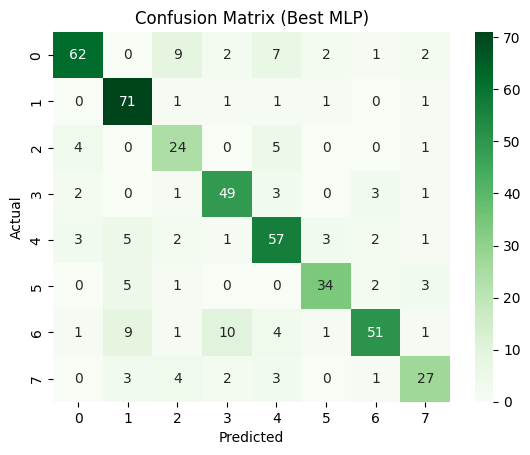

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, 
                          early_stopping=True, 
                          validation_fraction=0.1,
                          n_iter_no_change=15,
                          random_state=42))
])


param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128), (512, 256)],
    'mlp__alpha': [1e-4, 1e-5],
    'mlp__learning_rate_init': [0.001, 0.0005]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(x_train, y_train_encoded)

print("Best Parameters:", grid.best_params_)
print("Best Training Accuracy:", grid.best_score_)

y_pred = grid.predict(x_test)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))

cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Best MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## final improved model

In [21]:
minority_classes = [2, 3, 4, 6, 7]


In [22]:
# Create copies of the original training set
x_train_aug = x_train.copy()
y_train_aug = y_train_encoded.copy()

# Loop over each minority class and duplicate its samples
for cls in minority_classes:
    x_min = x_train[y_train_encoded == cls]
    y_min = y_train_encoded[y_train_encoded == cls]

    # Duplicate 2 times (adjust if needed)
    x_train_aug = np.concatenate([x_train_aug, x_min, x_min])
    y_train_aug = np.concatenate([y_train_aug, y_min, y_min])


In [23]:
train_df = pd.DataFrame(x_train_aug)
train_df['label'] = y_train_aug
test_df = pd.DataFrame(x_test)
test_df['label'] = y_test_encoded

# Drop low-performing emotion
emotion_to_drop = 7
train_df = train_df[train_df['label'] != emotion_to_drop]
test_df = test_df[test_df['label'] != emotion_to_drop]

# Recreate filtered splits
x_train_filtered = train_df.drop('label', axis=1).values
y_train_filtered = train_df['label'].values
x_test_filtered = test_df.drop('label', axis=1).values
y_test_filtered = test_df['label'].values

filtered_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(512, 256, 128) ,
                          max_iter=1000,
                          # alpha=1e-5,
                          alpha=0.0001,             # Slightly stronger regularization
                          batch_size=64,            # Smaller batches can help convergence
                          shuffle=True,
                          early_stopping=True,
                          validation_fraction=0.10,
                          learning_rate='adaptive',
                          random_state=42,
                          n_iter_no_change=20,
                          solver='adam'
                         )
    )
])


filtered_pipeline.fit(x_train_filtered, y_train_filtered)



Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=64, early_stopping=True,
                               hidden_layer_sizes=(512, 256, 128),
                               learning_rate='adaptive', max_iter=1000,
                               n_iter_no_change=20, random_state=42))])


Final Accuracy after improvements: 0.8093126385809313

Final F1 Score: 0.8080758447207063

Final Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77        85
           1       0.82      0.91      0.86        76
           2       0.74      0.85      0.79        34
           3       0.76      0.81      0.79        59
           4       0.77      0.91      0.83        74
           5       0.94      0.76      0.84        45
           6       0.77      0.78      0.78        78

    accuracy                           0.81       451
   macro avg       0.82      0.81      0.81       451
weighted avg       0.82      0.81      0.81       451



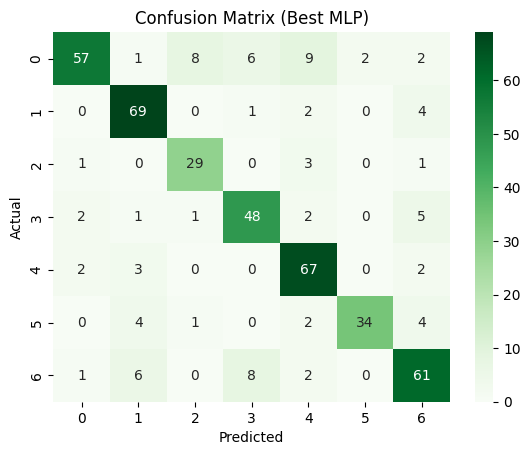

In [24]:
# Predict and Evaluate
y_pred_filtered = filtered_pipeline.predict(x_test_filtered)
acc = accuracy_score(y_test_filtered, y_pred_filtered)
f1 = f1_score(y_test_filtered, y_pred_filtered, average='weighted') 

print("\nFinal Accuracy after improvements:", acc)
print("\nFinal F1 Score:", f1)
print("\nFinal Classification Report:")
print(classification_report(y_test_filtered, y_pred_filtered))


cm = confusion_matrix(y_test_filtered, y_pred_filtered)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Best MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# Save the trained model
joblib.dump(filtered_pipeline, 'final_emotion_model.pkl')
print("Model saved as 'final_emotion_model.pkl'")


Model saved as 'final_emotion_model.pkl'
